## Stock Market Forecasting using ARIMA

In [6]:
# imports
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import pandas_datareader as pdr
key=""

In [7]:
df = pdr.get_data_tiingo('AMZN', api_key="5b1dc91669e1c851407c34549b5a39e8e45215f7")#amazon.com
df.to_csv('AMZN.csv')
df=pd.read_csv('AMZN.csv')

C:\Users\ADMIN\anaconda3\lib\site-packages\pandas_datareader\tiingo.py:234: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  return pd.concat(dfs, self._concat_axis)


In [8]:
df.head()

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,AMZN,2017-04-10 00:00:00+00:00,907.04,908.51,899.0000,899.63,3184301,907.04,908.51,899.0000,899.63,3184301,0.0,1.0
1,AMZN,2017-04-11 00:00:00+00:00,902.36,911.24,897.5000,907.04,3012743,902.36,911.24,897.5000,907.04,3012743,0.0,1.0
2,AMZN,2017-04-12 00:00:00+00:00,896.23,904.09,895.2501,903.09,2456140,896.23,904.09,895.2501,903.09,2456140,0.0,1.0
3,AMZN,2017-04-13 00:00:00+00:00,884.67,894.97,884.4900,891.45,3174583,884.67,894.97,884.4900,891.45,3174583,0.0,1.0
4,AMZN,2017-04-17 00:00:00+00:00,901.99,902.38,887.5000,887.50,2854673,901.99,902.38,887.5000,887.50,2854673,0.0,1.0


In [9]:
df.tail()

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
1253,AMZN,2022-03-31 00:00:00+00:00,3259.95,3329.90,3259.0700,3328.895,2998289,3259.95,3329.90,3259.0700,3328.895,2998289,0.0,1.0
1254,AMZN,2022-04-01 00:00:00+00:00,3271.20,3316.54,3246.3900,3282.990,2854475,3271.20,3316.54,3246.3900,3282.990,2854475,0.0,1.0
1255,AMZN,2022-04-04 00:00:00+00:00,3366.93,3367.89,3264.1100,3282.500,2500398,3366.93,3367.89,3264.1100,3282.500,2500398,0.0,1.0
1256,AMZN,2022-04-05 00:00:00+00:00,3281.10,3362.21,3265.3201,3354.830,2619553,3281.10,3362.21,3265.3201,3354.830,2619553,0.0,1.0
1257,AMZN,2022-04-06 00:00:00+00:00,3175.12,3244.00,3145.0900,3233.010,3952788,3175.12,3244.00,3145.0900,3233.010,3952788,0.0,1.0


In [10]:
print('earliest date:', df['date'].min())
print('latest date:', df['date'].max())

earliest date: 2017-04-10 00:00:00+00:00
latest date: 2022-04-06 00:00:00+00:00


In [11]:
df.Date = pd.to_datetime(df.date, format='%Y%m%d', errors='ignore')

C:\Users\ADMIN\AppData\Local\Temp/ipykernel_16376/233611192.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.Date = pd.to_datetime(df.date, format='%Y%m%d', errors='ignore')


## Data preprocessing

This step includes removing columns we do not need, check missing values, etc.

In [12]:
# filtering out unnecessary columns
cols = ['open', 'high', 'low', 'volume']
df.drop(cols, axis=1, inplace=True)
df = df.sort_values('date')

In [13]:
# checking for any missing values
df.isnull().sum()

symbol         0
date           0
close          0
adjClose       0
adjHigh        0
adjLow         0
adjOpen        0
adjVolume      0
divCash        0
splitFactor    0
dtype: int64

In [14]:
df = df.groupby('date')['close'].sum().reset_index()

In [15]:
# here is the final df, with only date and closing price
df.head()

,date,close
0,2017-04-10 00:00:00+00:00,907.04
1,2017-04-11 00:00:00+00:00,902.36
2,2017-04-12 00:00:00+00:00,896.23
3,2017-04-13 00:00:00+00:00,884.67
4,2017-04-17 00:00:00+00:00,901.99


## Indexing with Time Series data

In [16]:
df = df.set_index('date')
df.index

Index(['2017-04-10 00:00:00+00:00', '2017-04-11 00:00:00+00:00',
       '2017-04-12 00:00:00+00:00', '2017-04-13 00:00:00+00:00',
       '2017-04-17 00:00:00+00:00', '2017-04-18 00:00:00+00:00',
       '2017-04-19 00:00:00+00:00', '2017-04-20 00:00:00+00:00',
       '2017-04-21 00:00:00+00:00', '2017-04-24 00:00:00+00:00',
       ...
       '2022-03-24 00:00:00+00:00', '2022-03-25 00:00:00+00:00',
       '2022-03-28 00:00:00+00:00', '2022-03-29 00:00:00+00:00',
       '2022-03-30 00:00:00+00:00', '2022-03-31 00:00:00+00:00',
       '2022-04-01 00:00:00+00:00', '2022-04-04 00:00:00+00:00',
       '2022-04-05 00:00:00+00:00', '2022-04-06 00:00:00+00:00'],
      dtype='object', name='date', length=1258)

I have tried different ways to fill NA values, bfill seems to get the best results.

In [17]:
df.index = pd.to_datetime(df.index)
daily = df.close.resample('D')
daily = daily.fillna(method='bfill')
daily

date
2017-04-10 00:00:00+00:00     907.04
2017-04-11 00:00:00+00:00     902.36
2017-04-12 00:00:00+00:00     896.23
2017-04-13 00:00:00+00:00     884.67
2017-04-14 00:00:00+00:00     901.99
                              ...   
2022-04-02 00:00:00+00:00    3366.93
2022-04-03 00:00:00+00:00    3366.93
2022-04-04 00:00:00+00:00    3366.93
2022-04-05 00:00:00+00:00    3281.10
2022-04-06 00:00:00+00:00    3175.12
Freq: D, Name: close, Length: 1823, dtype: float64

## Visualizing Close Time Series data

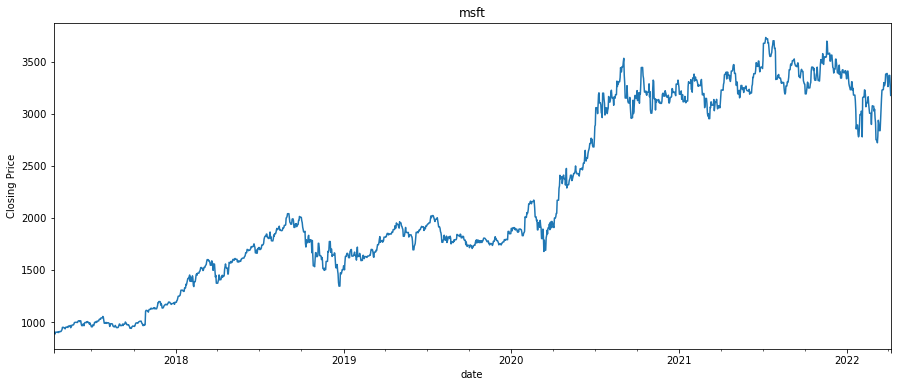

In [18]:
daily.plot(figsize=(15, 6))
plt.title('msft')
plt.ylabel('Closing Price')
plt.show()

## Time series forecasting with ARIMA

We are going to apply one of the most commonly used method for time-series forecasting, known as ARIMA, which stands for Autoregressive Integrated Moving Average.

Parameter Selection for the ARIMA Time Series Model. ARIMA models are denoted with the notation `ARIMA(p, d, q)`. These three parameters account for seasonality, trend, and noise in data.

In [19]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [20]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(daily,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:33480.34720475353
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:30935.44667170824
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:22646.059504255543
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:22494.53183059458
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:22645.51610379809
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:22616.269813203275
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:22509.04149613329
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:22486.494924986102
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:32112.424572627053
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:28553.43354708694
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:21182.568519122735
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:20951.33513803938
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:21198.407268256284
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:21061.809349451
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:20989.47583126333
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:20949.58834466659
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:18486.972488588413
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:18375.674349333916
ARIM

In [21]:
mod = sm.tsa.statespace.SARIMAX(daily,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9190      0.050     18.513      0.000       0.822       1.016
ma.L1         -0.9389      0.042    -22.109      0.000      -1.022      -0.856
ar.S.L12      -0.0236      0.023     -1.041      0.298      -0.068       0.021
ma.S.L12      -1.0000     16.789     -0.060      0.953     -33.905      31.905
sigma2      1509.0370   2.53e+04      0.060      0.953   -4.82e+04    5.12e+04


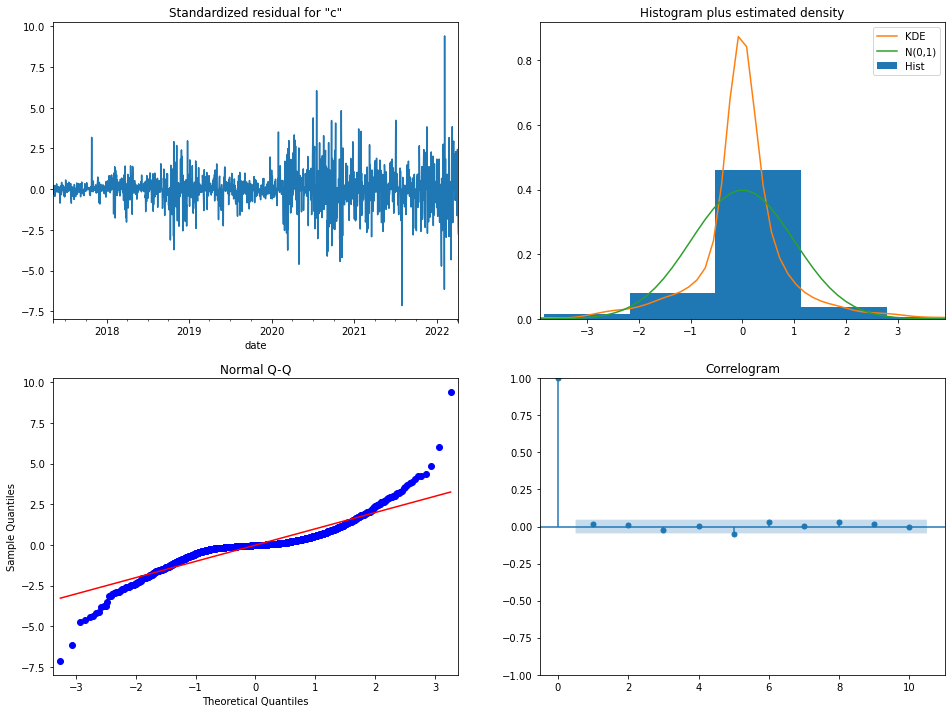

In [22]:
results.plot_diagnostics(figsize=(16, 12))
plt.show()

In the top right plot, we see that the red KDE line follows closely with the N(0,1) line (where N(0,1)) is the standard notation for a normal distribution with mean 0 and standard deviation of 1). This is a good indication that the residuals are normally distributed.

The qq-plot on the bottom left shows that the ordered distribution of residuals (blue dots) follows the linear trend of the samples taken from a standard normal distribution with N(0, 1). Again, this is a strong indication that the residuals are normally distributed.

The residuals over time (top left plot) don’t display any obvious seasonality and appear to be white noise. This is confirmed by the autocorrelation (i.e. correlogram) plot on the bottom right, which shows that the time series residuals have low correlation with lagged versions of itself.

## Forecasts

Graph doesn't seem to include seasonality. I choose not to force any additional noise into the forecast, and will be taking the predicted mean instead.

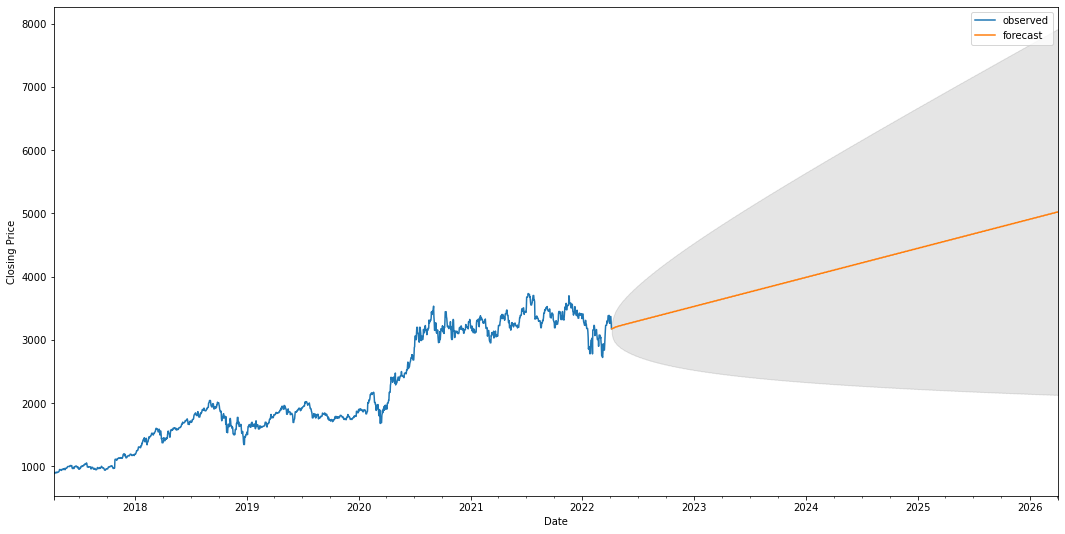

In [23]:
pred_uc = results.get_forecast(steps=1459) 
pred_ci = pred_uc.conf_int()

ax = daily.plot(label='observed', figsize=(18, 9))
pred_uc.predicted_mean.plot(ax=ax, label='forecast')

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=0.1)
                
ax.set_xlabel('Date')
ax.set_ylabel('Closing Price')

plt.legend()
plt.show()

In [24]:
pred_uc.predicted_mean

2022-04-07 00:00:00+00:00    3173.324774
2022-04-08 00:00:00+00:00    3177.082693
2022-04-09 00:00:00+00:00    3177.021039
2022-04-10 00:00:00+00:00    3178.964843
2022-04-11 00:00:00+00:00    3180.598983
                                ...     
2026-03-31 00:00:00+00:00    5017.421126
2026-04-01 00:00:00+00:00    5018.683266
2026-04-02 00:00:00+00:00    5018.165561
2026-04-03 00:00:00+00:00    5018.284064
2026-04-04 00:00:00+00:00    5022.744148
Freq: D, Name: predicted_mean, Length: 1459, dtype: float64

In [34]:
import datetime
datetime.datetime.now()

datetime.datetime(2022, 4, 7, 21, 9, 46, 724750)

In [51]:
pred_uc = pred_uc.predicted_mean
#pred_uc.columns = ['predicted1','predicted2', 'predicted_n']

In [74]:
df3=pred_uc.to_frame().reset_index()
import matplotlib.pyplot as plt

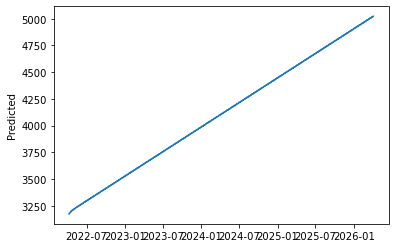

In [75]:
df3.columns=['Date','Predicted']
plt.plot(df3['Date'],df3['Predicted'])
#plt.xlabel('Date')
plt.ylabel('Predicted')
plt.show()
df3.to_csv('D:\MAJOR PROJECT\PHASE-2\predictedAMZN1.csv', index=False)